In [1]:
!pip install langgraph langchain langsmith transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.0 MB/s eta 0:00:00


In [15]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGSMITH_API_KEY")

In [17]:
import os
from typing import TypedDict, List
from langsmith import traceable, Client
from langgraph.graph import StateGraph, START, END
from transformers import pipeline

# --- LangSmith setup ---
client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# --- State definition ---
class MeetingState(TypedDict):
    transcript: str
    sections: List[str]
    summaries: List[str]
    final_notes: str
    reviewer_comments: str

# --- Orchestrator: splits transcript by speaker  ---
@traceable(run_type="tool", name="Orchestrator")
def orchestrator_node(state: MeetingState):
    lines = [line for line in state["transcript"].split("\n") if line.strip()]
    sections = []
    chunk = []
    CHUNK_SIZE = 3
    for idx, line in enumerate(lines):
        chunk.append(line)
        if len(chunk) == CHUNK_SIZE or idx == len(lines) - 1:
            sections.append("\n".join(chunk))
            chunk = []
    state["sections"] = sections
    print(f"Orchestrator: {len(sections)} sections found.")
    return state

# --- Synthesizer: LLM-based summarization of each section ---
@traceable(run_type="tool", name="Synthesizer (LLM)")
def synthesizer_node(state: MeetingState):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summaries = []
    for section in state["sections"]:
        summary = summarizer(section, max_length=50, min_length=20, do_sample=False)[0]['summary_text']
        summaries.append(summary)
    state["summaries"] = summaries
    state["final_notes"] = "\n\n".join(summaries)
    print("Synthesizer: All sections summarized.")
    return state


@traceable(run_type="tool", name="Human Review")
def human_review_node(state: MeetingState):
    print("\n=== FINAL SUMMARIZED NOTES ===\n")
    print(state["final_notes"])
    comment = input("Any reviewer comments or edits? (Type or Enter to accept): ")
    if comment.strip():
        state["final_notes"] += "\n[Reviewer]: " + comment
    state["reviewer_comments"] = comment
    return state


@traceable(run_type="tool", name="Archive")
def archive_node(state: MeetingState):
    import json
    with open("meeting_notes_archive.json", "a") as f:
        f.write(json.dumps(state) + "\n")
    print("Notes archived and workflow complete.")
    return state




/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [18]:
# --- Graph assembly ---
graph = StateGraph(MeetingState)
graph.add_node("orchestrator", orchestrator_node)
graph.add_node("synthesizer", synthesizer_node)
graph.add_node("human_review", human_review_node)
graph.add_node("archive", archive_node)

graph.add_edge(START, "orchestrator")
graph.add_edge("orchestrator", "synthesizer")
graph.add_edge("synthesizer", "human_review")
graph.add_edge("human_review", "archive")
graph.add_edge("archive", END)

meeting_graph = graph.compile()


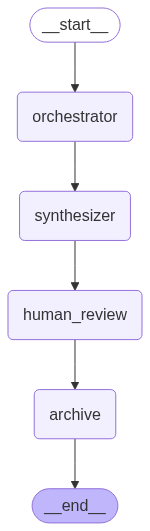

In [19]:
from IPython.display import Image, display
display(Image(meeting_graph.get_graph().draw_mermaid_png()))

In [20]:
# --- Run  test workflow ---
if __name__ == "__main__":
    transcript = """
    Speaker 1: Good morning, everyone. Let's start with our Q3 project updates.
    Speaker 2: Thanks, Speaker 1. The web app migration is almost done, but we've hit a snag with authentication—OAuth tokens are expiring too soon.
    Speaker 3: We've had several user complaints about login issues. Should we escalate to IT Security?
    Speaker 4: Yes, please loop in IT. Also, Speaker 2, can you document the token flow bug and send it to the backlog?
    Speaker 2: Absolutely, I’ll write up a ticket today. On a related note, the UI refresh for mobile is 80% complete. We need assets from the design team to finish.
    Speaker 1: Noted. Design, can you prioritize mobile assets?
    Speaker 5: We're on it. Expect initial drafts by Thursday. Also, we're revamping the color palette for better accessibility.
    Speaker 3: Speaking of accessibility, several users with screen readers had issues navigating the new dashboard.
    Speaker 4: That’s a critical blocker. Please coordinate with QA for accessibility testing.
    Speaker 2: Will do. On the infrastructure side, cloud costs spiked last week—primarily from large batch data jobs.
    Speaker 1: Can someone analyze which jobs triggered the spike?
    Speaker 3: I’ll take that action. Also, our release schedule is tight; do we have room to slip the October sprint?
    Speaker 1: Not really, but let’s flag high-risk items and communicate early.
    Speaker 5: Quick update: the marketing team requests a new landing page for the October campaign.
    Speaker 1: Please gather requirements and share a draft by next week.
    Speaker 2: One more thing: we have three open critical bugs in the API. Fixes should be ready by tomorrow.
    Speaker 4: Thanks, everyone. Let's summarize action items before we adjourn.
    Speaker 1: Sure! (1) IT Security to review authentication bug. (2) Design to deliver mobile assets and accessibility review. (3) QA to expand dashboard accessibility tests. (4) Speaker 3 to analyze cloud costs. (5) Speaker 2 to resolve API bugs. (6) Marketing draft due next week.
    Speaker 1: Anything else?
    Speaker 5: All good here.
    Speaker 2: Nothing from me.
    Speaker 3: No, thanks.
    Speaker 4: Meeting adjourned. Thanks all.
    """

    state = {
        "transcript": transcript,
        "sections": [],
        "summaries": [],
        "final_notes": "",
        "reviewer_comments": "",
    }
    print("Automated Meeting Notes Workflow (LangGraph + LLM + LangSmith)")
    result = meeting_graph.invoke(state)
    print("\n=== Final Output ===\n")
    print(result["final_notes"])

Automated Meeting Notes Workflow (LangGraph + LLM + LangSmith)
Orchestrator: 8 sections found.


Device set to use cpu
Your max_length is set to 50, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 50, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Synthesizer: All sections summarized.

=== FINAL SUMMARIZED NOTES ===

Speaker 1: Let's start with our Q3 project updates. Speaker 2: Thanks, Speaker 1. Speaker 3: We've had several user complaints about login issues. Should we escalate to IT Security?

Speakers: Can you document the token flow bug and send it to the backlog? Speaker 2: Absolutely, I’ll write up a ticket today. On a related note, the UI refresh for mobile is 80% complete.

Several users with screen readers had issues navigating the new dashboard. We're revamping the color palette for better accessibility. Expect initial drafts by Thursday.

Cloud costs spiked last week,primarily from large batch data jobs. Can someone analyze which jobs triggered the spike?

Speaker 1: Please gather requirements and share a draft by next week. Speaker 5: Quick update: the marketing team requests a new landing page for the October campaign.

We have three open critical bugs in the API. Fixes should be ready by tomorrow. Marketing draft 